# Classification Models

In this notebook, we will perform data preprocessing and build classifiers for the pollen count data. We will also apply feature selection methods on the dataset. We will try several classification models to compare and discuss the most reasonable and appropriate model.

In [1]:
from logging import warning
import pickle
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import Normalizer

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score, f1_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Preprocessing

At the beginning, we assign the label for each instance according to the pollun counts. And the label spliting standard is based on [Melbourne Pollen](https://www.melbournepollen.com.au/)

$$ 
\text{Label} =
    \left \{ 
    \begin{aligned} 
        1 \quad & \text{if}\quad 0  \leq \text{pollen count} < 20 \\ 
        2 \quad & \text{if}\quad 20 \leq \text{pollen count} < 50 \\ 
        3 \quad & \text{if}\quad 50 \leq \text{pollen count} < 100 \\ 
        4 \quad & \text{if}\quad         \text{pollen count} \geq 100 \\ 
        
    \end{aligned} 
    \right. 
$$

In [2]:
# load weather data
weather_dict = pickle.load(open('../weather_v2.pkl', "rb"))


# add grass count data and assigned by labels
grass_df = pd.read_csv('../preprocessing/clean_data.csv')

grass_df['Count Date'] = grass_df['Count Date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'))
grass_df['non_grass'] = grass_df['Total'] - grass_df['grass_count']

label = [[100, 4], [50, 3], [20, 2], [-1, 1]]

def get_label(x):
    for i in label:
        if x >= i[0]:
            return i[1]

grass_df['label'] = grass_df['grass_count'].apply(lambda x:get_label(x))

In [3]:
# data from 2008
data_2008 = pd.read_csv("../preprocessing/data_2008.csv")
data_2008.head()

,coord,t_mean_9am,t_min_9am,t_max_9am,t_sd_9am,t_2m_mean_9am,t_2m_min_9am,t_2m_max_9am,t_2m_sd_9am,msl_mean_9am,...,u_10m_sd_4pm,v_10m_mean_4pm,v_10m_min_4pm,v_10m_max_4pm,v_10m_sd_4pm,pwat_mean_4pm,pwat_min_4pm,pwat_max_4pm,pwat_sd_4pm,date
0,"(145,-38)",285.875,280.1,290.8,4.78008,285.75,280.4,290.3,4.430575,101775.75,...,0.499166,3.300,1.499999,6.0,1.961293,13.875,13.0,14.9,0.880814,2000-01-01
1,"(145,-38)",285.875,280.1,290.8,4.78008,285.75,280.4,290.3,4.430575,101775.75,...,1.175797,-2.450,-8.000000,2.9,5.402777,16.925,13.6,20.0,2.780138,2000-01-02
2,"(145,-38)",285.875,280.1,290.8,4.78008,285.75,280.4,290.3,4.430575,101775.75,...,2.538208,3.100,1.099999,5.7,1.971464,22.625,18.8,24.7,2.617091,2000-01-03
3,"(145,-38)",285.875,280.1,290.8,4.78008,285.75,280.4,290.3,4.430575,101775.75,...,2.053453,4.850,3.500000,6.2,1.161895,16.400,12.3,20.2,3.799123,2000-01-04
4,"(145,-38)",285.875,280.1,290.8,4.78008,285.75,280.4,290.3,4.430575,101775.75,...,0.618467,3.975,2.800000,5.6,1.286792,14.550,13.4,15.1,0.776745,2000-01-05


For every city count the number of instances

In [4]:
grass_df['Name'] = grass_df['Name'].apply(lambda x:x.split('_')[0])
grass_df['Name'].value_counts()

Sydney                 4454
Tasmania               4049
Melbourne              2842
NSW-Westmead           1342
Canberra(2007-2017)    1301
Canberra                995
NSW-Gosford             854
NT                      809
Burwood                 406
Creswick                404
Geelong                 401
Dookie                  374
Churchill               365
Hamilton                355
Bendigo                 352
NSW-Wagga               247
Name: Name, dtype: int64

Filter the data in **Melbourne** and merge the pollen data and the weather data as the train dataset

In [5]:
# weather_dict[1]
grass_columns = ['Count Date', 'Elevation', 'Total', 'Location', 'SchColTime', 'grass_count', 'label']
data = grass_df.loc[grass_df['Name']=='Melbourne'][grass_columns]
data

melbourne_df = pd.DataFrame()
weather_dict[1]['date'] = weather_dict[1].index
for i in [1, 25, 28, 29]:
    tmp = pd.merge(data.loc[data['Location']==i], weather_dict[1], left_on='Count Date', right_on='date', how='left')
    melbourne_df = pd.concat([melbourne_df, tmp])

full_data = melbourne_df.drop(['Count Date', 'SchColTime', 'date'], axis=1)
full_data.head()

,Elevation,Total,Location,grass_count,label,av_abl_ht,accum_prcp,av_lwsfcdown,av_mslp,av_qsair_scrn,...,thermal_time_1D,thermal_time_10D,thermal_time_30D,thermal_time_90D,thermal_time_180D,soil_mois_1D,soil_mois_10D,soil_mois_30D,soil_mois_90D,soil_mois_180D
0,28.0,76.0,1,0.0,1.0,567.409722,0.014479,291.515625,101588.000000,0.004978,...,3.625,35.250,87.500,87.500,486.375,1792.332031,24080.046875,71414.628906,209709.917969,415718.011719
1,28.0,335.0,1,0.0,1.0,672.985000,0.044749,316.624375,101377.280000,0.004932,...,4.375,36.250,89.250,89.250,487.500,2489.031250,24086.992188,71454.339844,209820.257812,415804.148438
2,28.0,857.0,1,3.0,1.0,1351.370000,0.038105,320.018125,100350.040000,0.005645,...,3.500,36.500,90.875,90.875,487.375,2488.683594,24090.761719,71490.339844,209930.417969,415890.109375
3,28.0,235.0,1,0.0,1.0,896.015000,0.011231,318.508125,101197.400000,0.005693,...,2.750,36.125,91.000,91.000,487.000,2488.316406,24092.531250,71522.316406,210040.222656,415975.867188
4,28.0,263.0,1,0.0,1.0,1343.250000,0.055731,309.666466,101231.692308,0.005118,...,3.250,36.125,91.125,91.125,487.500,2587.183594,24192.238281,71650.304688,210248.914062,416160.636719


Generate the full dataset with dropped nan values and time columns

In [6]:
full_data = melbourne_df.drop(['Count Date', 'SchColTime', 'date'], axis=1).dropna()
full_data.head()

,Elevation,Total,Location,grass_count,label,av_abl_ht,accum_prcp,av_lwsfcdown,av_mslp,av_qsair_scrn,...,thermal_time_1D,thermal_time_10D,thermal_time_30D,thermal_time_90D,thermal_time_180D,soil_mois_1D,soil_mois_10D,soil_mois_30D,soil_mois_90D,soil_mois_180D
0,28.0,76.0,1,0.0,1.0,567.409722,0.014479,291.515625,101588.000000,0.004978,...,3.625,35.250,87.500,87.500,486.375,1792.332031,24080.046875,71414.628906,209709.917969,415718.011719
1,28.0,335.0,1,0.0,1.0,672.985000,0.044749,316.624375,101377.280000,0.004932,...,4.375,36.250,89.250,89.250,487.500,2489.031250,24086.992188,71454.339844,209820.257812,415804.148438
2,28.0,857.0,1,3.0,1.0,1351.370000,0.038105,320.018125,100350.040000,0.005645,...,3.500,36.500,90.875,90.875,487.375,2488.683594,24090.761719,71490.339844,209930.417969,415890.109375
3,28.0,235.0,1,0.0,1.0,896.015000,0.011231,318.508125,101197.400000,0.005693,...,2.750,36.125,91.000,91.000,487.000,2488.316406,24092.531250,71522.316406,210040.222656,415975.867188
4,28.0,263.0,1,0.0,1.0,1343.250000,0.055731,309.666466,101231.692308,0.005118,...,3.250,36.125,91.125,91.125,487.500,2587.183594,24192.238281,71650.304688,210248.914062,416160.636719


#### Randomly Re-Sample
Generate variables in dataframe as `X_origin`, choose the label as target as `Y_origin`. </br>
Since the labels in raw data doesn't distribute evenly, so we use the `RandomOverSample` method to resample the data. ***

In [7]:
full_data.label.value_counts()

1.0    1159
2.0     464
3.0     250
4.0     196
Name: label, dtype: int64

In [8]:
X_origin = full_data.drop(['label', 'Total', 'Location', 'grass_count'], axis=1).reset_index(drop=True)
Y_origin = full_data['label']

X_origin, Y_origin = RandomOverSampler(random_state=0).fit_resample(X_origin, Y_origin)
print(Y_origin.value_counts())

1.0    1159
2.0    1159
3.0    1159
4.0    1159
Name: label, dtype: int64


In [9]:
X_origin.shape

(4636, 172)

# Modelling

### Benchmark

The `sklearn.ensemble.GradientBoostingClassifier` is used as benchmark model.

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score


X_train, X_test, Y_train, Y_test = train_test_split(X_origin, Y_origin, test_size=0.33, random_state=88)

model = GradientBoostingClassifier()
model.fit(X_train, Y_train)
model.score(X_test, Y_test)

0.8522875816993464

### Model Evaluation

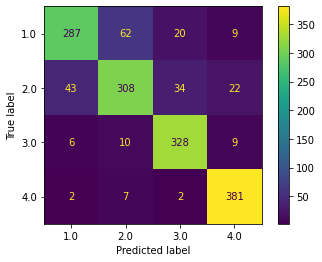

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Y_pred = model.predict(X_test)

# confusion_matrix(Y_test, Y_pred)
cm = confusion_matrix(Y_test, Y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()

plt.show()

In [12]:
from sklearn.metrics import classification_report

class_report = classification_report(Y_test, Y_pred)
print(class_report)

              precision    recall  f1-score   support

         1.0       0.85      0.76      0.80       378
         2.0       0.80      0.76      0.78       407
         3.0       0.85      0.93      0.89       353
         4.0       0.90      0.97      0.94       392

    accuracy                           0.85      1530
   macro avg       0.85      0.85      0.85      1530
weighted avg       0.85      0.85      0.85      1530



In [10]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

model = OneVsRestClassifier(GradientBoostingClassifier())

y_score = model.fit(X_train, Y_train).decision_function(X_test)

In [14]:
def transform(y):
    result = np.zeros([len(y), 4])
    for i in range(len(y)):
        result[i, int(y[i]-1)] += 1
    return result

Y_test = transform(Y_test.to_numpy())

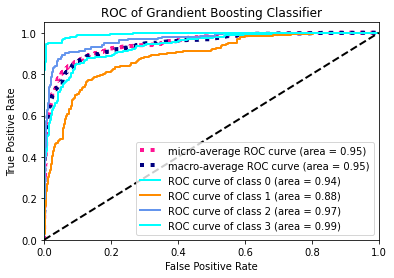

In [15]:
n_classes = 4
lw = 2

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC of Grandient Boosting Classifier")
plt.legend(loc="lower right")
plt.show()

Check the overfitting of model.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  25 | elapsed:   15.5s remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  5.5min finished


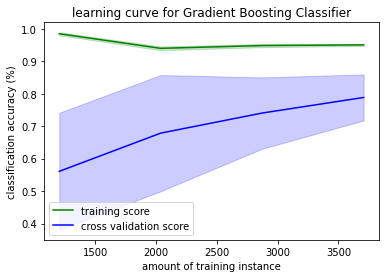

In [16]:
from support_evaluation import check_overfitting
check_overfitting(GradientBoostingClassifier(), X_origin, Y_origin)

The plot of learning curve of `GradientBoostingClassifier` model presents that the classification accuracy of training score is always larger than cross validation score, which presents the overfitting of model.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import time

def grid_search(pipeline, parameters, X, y):
    gs = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
    
    print('Performing grid search...')
    print('pipeline:', [name for name, _ in pipeline.steps])
    print('parameters:')
    print(parameters)
    t0 = time.time()
    gs.fit(X, y)
    print('done in %0.3fs' % (time.time() - t0))
    print()
    
    # print out best 5 results
    mean_score = gs.cv_results_['mean_test_score']
    param_set = gs.cv_results_['params']
    for i in mean_score.argsort()[-5:]:
        print(param_set[i])
        print(gs.cv_results_['mean_test_score'][i])
        print('='*30)
    
    return gs

In [26]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_regression, f_classif, mutual_info_regression


pipeline = Pipeline(
    [
        ('kbest', SelectKBest()),
        ('clf', GradientBoostingClassifier())
    ]
)

# parameters={
#     'clf__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
#     'clf__activation': ['tanh', 'relu'],
#     'clf__solver': ['sgd', 'adam'],
#     'clf__alpha': [0.0001, 0.05],
#     'clf__learning_rate': ['constant','adaptive'],
# }

parameters = {
    'kbest__score_func': (f_classif, mutual_info_classif),
    'kbest__k':(20, 50, 100, 150, 'all'),
    # "clf__loss":["deviance"],
    "clf__learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    # "clf__max_features":["log2","sqrt"],
    # "clf__criterion": ["friedman_mse",  "mae"],
    }


In [24]:
gs = grid_search(pipeline, parameters, X_origin, Y_origin)

Performing grid search...
pipeline: ['kbest', 'clf']
parameters:
{'kbest__score_func': (<function f_regression at 0x13cc84c10>, <function mutual_info_regression at 0x13cc87370>), 'kbest__k': (20, 50, 100, 150, 'all'), 'clf__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2]}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
done in 2256.210s

{'clf__learning_rate': 0.2, 'kbest__k': 50, 'kbest__score_func': <function f_regression at 0x13cc84c10>}
0.836739528698434
{'clf__learning_rate': 0.2, 'kbest__k': 150, 'kbest__score_func': <function f_regression at 0x13cc84c10>}
0.8391046386192016
{'clf__learning_rate': 0.2, 'kbest__k': 150, 'kbest__score_func': <function mutual_info_regression at 0x13cc87370>}
0.8442877469032473
{'clf__learning_rate': 0.2, 'kbest__k': 20, 'kbest__score_func': <function f_regression at 0x13cc84c10>}
0.8449126771565674
{'clf__learning_rate': 0.2, 'kbest__k': 100, 'kbest__score_func': <function mutual_info_regression at 0x13cc87370>}
0.8455815478183238


In [60]:
def print_scores(y_test, y_pred):
    print('='*10 + 'Evaluation results' + '='*10)
    print('The accuracy  : {}'.format(accuracy_score(y_test, y_pred)))
    print('  The recall  : {}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('      The f1  : {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [61]:
classif_y_test = []
for i in Y_test:
    for j in range(4):
        if i[j] == 1:
            classif_y_test.append(j+1)
# classif_y_test
print_scores(classif_y_test, Y_pred)

==========Evaluation results==========
The accuracy  : 0.8522875816993464
  The recall  : 0.8522875816993464
      The f1  : 0.8499602749809874


In [62]:
regression_test_df = pd.read_csv('../../preprocessing/result_baseline.csv')
regression_test_df['test_label'] = regression_test_df.test.apply(lambda x:get_label(x))
regression_test_df['pred_label'] = regression_test_df.tune_param.apply(lambda x:get_label(x))
regression_test_df.head()

,Unnamed: 0,test,baseline,tune_param,fea_selc,test_label,pred_label
0,2020-10-02,37.0,11.0,12.0,7.0,2,1
1,2020-10-03,75.0,18.0,15.0,7.0,3,1
2,2020-10-04,69.0,17.0,20.0,9.0,3,2
3,2020-10-05,47.0,14.0,9.0,25.0,2,1
4,2020-10-06,1.0,7.0,4.0,2.0,1,1


In [64]:
regression_gfs_df = pd.read_csv('../../preprocessing/resulr_gfs.csv')
regression_gfs_df['test_label'] = regression_gfs_df.test.apply(lambda x:get_label(x))
regression_gfs_df['pred_label'] = regression_gfs_df.tune_param.apply(lambda x:get_label(x))
regression_gfs_df.head()

,Unnamed: 0,test,baseline,tune_param,test_label,pred_label
0,2007-10-01,3.0,4.0,11.0,1,1
1,2007-10-02,6.0,29.0,23.0,1,2
2,2007-10-03,8.0,0.0,0.0,1,1
3,2007-10-04,2.0,0.0,12.0,1,1
4,2007-10-05,6.0,0.0,9.0,1,1


In [67]:

print("regression for backup")
print_scores(regression_test_df.test_label, regression_test_df.pred_label)

print("\nregression for gfs")
print_scores(regression_gfs_df.test_label, regression_gfs_df.pred_label)

regression for backup
==========Evaluation results==========
The accuracy  : 0.5163934426229508
  The recall  : 0.5163934426229508
      The f1  : 0.541521456685391

regression for gfs
==========Evaluation results==========
The accuracy  : 0.5054945054945055
  The recall  : 0.5054945054945055
      The f1  : 0.47511706852366187
